# Bayesci Negatif Olmayan Matris Ayrışımı için Aktif Eleman Seçimi
# Active Selection of Elements for Bayesian Nonnegative Matrix Factorization

<br>
<center>  Burak Suyunu, Gönül Aycı, A.Taylan Cemgil </center>
<center> * Bilgisayar Mühendisliği Bölümü, Boğaziçi Üniversitesi </center>
<center> * {burak.suyunu, gonul.ayci, taylan.cemgil}@boun.edu.tr </center>

## Özetçe

Klasik matris tamamlama problemlerinde elimizdeki matris, gözlemlenen ve bilinmeyen elemanlar olarak iki gruba ayrılabilir. Bu çalışmadaki yaklaşımda ise matrisler üç farklı gruptan oluşmaktadır: bilinen ve masrafsız olarak her zaman erişebildigimiz gözlemlenmiş olan veri, tahmin etmeye çalıştığımız bilinmeyen veri ve şu an bilinmeyen ancak istenildigi zaman sorgulanabilen veri. Son gruptaki veriler ilk kez sorgulandığında bir maliyet ortaya çıkmaktadır. Bu gözlemden yola çıkarak, mümkün olduğu kadar az sorgu yaparak ikinci gruptaki bilinmeyen verideki değerleri en az hata ile tahminlemek istiyoruz. Amacımız, sorgulamaya çalıştığımız gözlemleri akıllıca seçebilmek. Bu çalışmamızda, gözlem sırası seçme stratejileri tanımlanarak MovieLens veri setinde karşılaştırılmıştır.

## Abstract
In classical matrix completion problems, you can divide the matrix into two groups as observed and unknown elements. In this study, the matrices are composed of three different groups: observed data that is known and accessible at any time without any expense, unknown data that we are trying to predict, and data that is currently unknown but can be queried when desired. When the data in the last group is queried for the first time, a cost arises. From this observation, we want to estimate the unknown data in the second group with the least error by making as few queries as possible. Our goal is to choose the observations we are trying to question wisely. In this study, observation sequence selections were defined and compared in
the MovieLens data set.

## Giriş
Negatif olmayan matris ayrıştırma yöntemi (NOMA), ilk olarak Lee ve Seung [1] tarafından önerilmiştir. Negatif olmayan matris ayrıştırması, verilen negatif olmayan bir *X* matrisinin negatif olamayan değerler içeren *T* ve *V* çarpanlarına ayırma yöntemidir. Elde edilen iki matrisin çarpımlarının değeri ayrıştırılan matrisin değerine yaklaşık olarak eşittir.

Öneri sistemlerinde ayrışım tabanlı yapılar sıklıkla kullanılmaktadır. Sistemin mantığı şu şekilde açıklanabilir. Bir *X* matrisi ile belirli bir süre aralıgında toplanmış olan kullanıcı-film ilişkisine dair verimizi gösterelim. Bu matrisin satırları filmleri, sütunları kullanıcıları, elemanları ise kullanıcıların filmlere vermiş oldugu puanlamaları temsil etmektedir. Eğer *X* matrisinin herhangi bir elemanının değeri yok ise, bu kullanıcı ve film arasında henüz bir ilişkinin olmadığını göstermektedir yani kullanıcı bu filme henüz herhangi bir oy vermemiştir. Kullanıcılara etkileşimli olarak film hakkındaki puanlamaları sorulabilir. Ancak herkesin her zaman her film hakkında puanlama yapması mümkün degildir. Dolayısıyla bir kişiye bir film hakkındaki puanını sorarken akıllıca bir yol izlemek gerekmektedir. Bu şekilde en az kişiden bilgi talep ederek, elde edilen bilgilerle kullanıcı-film arasındaki örüntüye ulaşmak ve bilmedigimiz veriler hakkındaki tahminlerimizi iyileştirmek istenmektedir.

<img src="senaryo.png" width="400px">
<figcaption>Şekil 1: **Senaryonun işlenişi:** Burada mavi hücreler maskelenmiş, kırmızılar test ve beyazlar ise gözlemlenmiş veriyi göstermektedir. Kırmızının koyuluğu hatanın fazlalığına işaret etmektedir. Bir veri gözlemlendiginde en çok bulunduğu satır ve sütun hakkında bilgi vermesi beklenmektedir. *Senaryo B*’nin test hücreleri hakkında verdiği bilgi *Senaryo A*’dan fazla olduğu görülmektedir.</figcaption>


**Senaryo:** Elimizde bir *X* matrisimiz olsun. Verilen *X* matrisine Gibbs örnekleyicisi ile negatif olmayan matris ayrıştırması yöntemi kullanarak yaklaşım yapıyoruz. Matrisimizi
bildiğimiz, bilmediğimiz (tahmin etmeye çalıştığımız) ve zaman içinde açarak gözlemleyeceğimiz (maskelenmiş) üç çeşit veriden oluşturuyoruz. Üçüncü kategorideki veriden belli yığınlarda ve minimum sayıda veri açarak maksimum bilgi edinmeyi ve en iyi tahminleme yapmayı hedefliyoruz. Bu gruptaki veriyi nasıl seçecegimiz konusunda tanımladığımız çeşitli gözlem sırası seçme stratejilerimizi karşılaştırıyoruz.

In [1]:
import numpy as np
import scipy as sp
import math
import time
from scipy import special
from scipy.stats import gamma
from scipy.stats import entropy
from scipy.integrate import simps
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
import random
import pandas as pd
from IPython.html.widgets import *
import operator

C:\Users\Burki\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## MovieLens Veri Seti

<cite>[MovieLens][1]</cite> veri setinde 700 kullanıcının 9000 filme vermiş olduğu 0,5 ile 5 puan arasında degişen toplam 100.000 oy bulunmaktadır. Modelimizdeki çok terimli dagılıma uygun bir girdi oluşturmak için oy puan aralıgını 0,5-5 ten 1-10 aralığına eşledik. 

[1]:https://grouplens.org/datasets/movielens/latest/
 

In [2]:
df_MovieLens = pd.read_csv('ratings.csv')
df_MovieLens

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
df_MovieLens.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [4]:
movieWatchedCount = {}
userWatchCount = {}

In [5]:
for m in df_MovieLens.movieId.unique():
    movieWatchedCount[m] = len(df_MovieLens[df_MovieLens.movieId == m])
for u in df_MovieLens.userId.unique():
    userWatchCount[u] = len(df_MovieLens[df_MovieLens.userId == u])

In [6]:
sorted_movieWatchedCount = sorted(movieWatchedCount.items(), key=operator.itemgetter(1), reverse=True)
sorted_userWatchCount = sorted(userWatchCount.items(), key=operator.itemgetter(1), reverse=True)

### Veri Matrisinin Oluşturulması

Yoğun veya seyrek matris oluşturma isteğinize göre alttaki hücrelerden sadece birini çalıştırın. <br>
Oluşturduğumuz matrisin satırları filmleri, sütunları kullanıcıları, elemanları ise kullanıcıların filmlere vermiş olduğu puanlamaları temsil etmektedir.

#### Yoğun Matrisin Üretilmesi

Yoğun veri seti için MovieLens’ten en çok film izlemiş 20 kullanıcı ve en çok izlenen 50 filmi kullandık.

In [7]:
# Number of Rows
# nu: 1 -> W
movieCount = 50

# Number of Columns
# tao: 1 -> K
userCount = 20

topMovies = np.asarray(sorted_movieWatchedCount)[:movieCount,0]
topUsers = np.asarray(sorted_userWatchCount)[:userCount,0]

userMovie = np.zeros((movieCount, userCount))

for i, m in enumerate(topMovies):
    for j, u in enumerate(topUsers):
        if len(df_MovieLens[(df_MovieLens.userId  == u) & (df_MovieLens.movieId == m)]) != 0:
            userMovie[i][j] = 2*float(df_MovieLens[(df_MovieLens.userId  == u) & (df_MovieLens.movieId == m)]['rating'])

#### Seyrek Matrisin Üretilmesi

Seyrek veri için ise her seferinde rastgele en çok izlenen 1000 filmden 50, en çok film izlemiş 200 kullanıcıdan 20 tanesini kullandık.

In [ ]:
# Number of Rows
# nu: 1 -> W
movieCount = 50

# Number of Columns
# tao: 1 -> K
userCount = 20

sparsityParameter = 13

movieIndex = np.random.permutation(movieCount*sparsityParameter)[:movieCount]
userIndex = np.random.permutation(userCount*sparsityParameter)[:userCount]

topMovies = []
topUsers = []

for mI in movieIndex:
    topMovies.append(sorted_movieWatchedCount[mI][0])
for uI in userIndex:
    topUsers.append(sorted_userWatchCount[uI][0])

topMovies = np.asarray(topMovies)
topUsers = np.asarray(topUsers)

userMovie = np.zeros((movieCount, userCount))

for i, m in enumerate(topMovies):
    for j, u in enumerate(topUsers):
        if len(df_MovieLens[(df_MovieLens.userId  == u) & (df_MovieLens.movieId == m)]) != 0:
            userMovie[i][j] = 2*float(df_MovieLens[(df_MovieLens.userId  == u) & (df_MovieLens.movieId == m)]['rating'])

### Maskeleme

Eksik veriyi yani $x_{\nu, \tau}$ gözlemlenmemiş değerlerini modellerken *X* matrisi ile aynı boyuta sahip olan $\textit{M} = \left \{ m_{\nu, \tau} \right \}$  *maske matrisi* aşağıdaki gibi tanımlanır:

<center>
$m_{\nu, \tau} = \left\{\begin{matrix}
 0,& x_{\nu, \tau} \text{ gözlemlenmemişse},\\ 
 1,& x_{\nu, \tau} \text{ gözlemlenmişse}.
\end{matrix}\right.$
</center>

Bu maskeyi kullanarak olabilirlik fonksiyonunu şu şekilde yazılır:

\begin{align*}
p(X,S\mid T,V) = \prod_{\nu, \tau}\left ( p\left (x_{\nu, \tau}\mid s_{\nu, 1:I, \tau}\right ) p\left (s_{\nu, 1:I, \tau}\mid t_{\nu, 1:I}, v_{1:I, \tau}  \right )\right )^{m_{\nu, \tau}}
\end{align*}


### Maskeleme Metodları

Bu çalışmamızda veriye *kısmi* ve *tam* olarak iki farklı açıdan yaklaşarak KL ıraksayı ve KOKH metrikleri (ileride açıklanacak) ile karşılaştırmalar yaptık. 

Kısmi yaklaşımda verimizi %30 test, %69 maskelenmiş, %1 başlangıçta bilinen olarak ayırdık. Maskelenmiş veriyi açtıkça değişen test üzerindeki hatayı ölçtük.

Tam yaklaşımda ise %99 maskelenmiş, %1 başlangıçta bilinen olarak ayırdık ve hatayı bütün veri üzerinden ölçtük.

In [8]:
def randomMasking(W, K, dataExistance):
    dataIndices = np.argwhere(dataExistance>0)
    
    #test, mask, known
    mask = np.zeros([W,K])
    test = np.copy(dataExistance)
    
    np.random.shuffle(dataIndices)
    
    for i in range(30*len(dataIndices)//100):
        test[dataIndices[i][0], dataIndices[i][1]] = 0
    for i in range(30*len(dataIndices)//100, 31*len(dataIndices)//100):
        mask[dataIndices[i][0], dataIndices[i][1]] = 1
        
    return mask, test

### GÖZLEM SIRASI SEÇME STRATEJİLERİ

Bu çalışmada, maskelenmiş olan veriyi gözlemlemek için beş farklı gözlem sırası seçme stratejisi tanımladık.

Amacımız, en hızlı şekilde bütün veriyi ögrenebileceğimiz (yakınsayabilecegimiz) bilgi elde etme stratejisini bulmak ve ögrenme sonucunda test verisi hakkında doğru tahminlemede bulunmak.

#### Rastgele Strateji

**Tanım**: Rastgele bir pozisyonda yer alan maskelenmiş veri gözlemlenir. <br>
Gözlemlenmiş verideki bilgiyi kullanmadan maskelenmiş veriyi açar. Tanımlanan diğer stratejilerin işlevselliğini değerlendirmek için bir alt sınır oluşturur.

In [9]:
def openRandom(W, K, mask, test):
    openOrder = np.arange(W*K)
    random.shuffle(openOrder)
    
    for i in openOrder:
        if mask[i//K][i%K] == 0 and test[i//K][i%K] == 1:
            return i//K, i%K
        
    return -1, -1

#### Satır-Sütun Stratejileri

**Tanım**: Satır ve sütunlar en az veri gözlemlenenden en çok veri gözlemlenene dogru sıralanır. Satıra veya sütuna öncelik vererek kesişimlerindeki ilk maskelenmiş veri açılır. <br>
Bir veriyi tahmin ederken o veri hakkında en çok bilgi edinebilecegimiz yerler o verinin bulunduğu satır ve sütunundaki diger verilerdir. Düzenli olarak satır ve sütunlardaki gözlemlenmiş veri sayısını artırarak bütün veri hakkındaki tahminimizi iyileştirebiliriz.

In [10]:
def openMaxColMask(W, K, mask, test):
    colSum = mask.sum(0)
    rowSum = mask.sum(1)
    
    colMins = colSum.argsort()
    rowMins = rowSum.argsort()

    for c in colMins:
        for r in rowMins:
            if mask[r][c] == 0 and test[r][c] == 1:
                return r, c
            
    
    return openRandom(W, K, mask, test)


In [11]:
def openMaxRowMask(W, K, mask, test):
    colSum = mask.sum(0)
    rowSum = mask.sum(1)
    
    colMins = colSum.argsort()
    rowMins = rowSum.argsort()

    for r in rowMins:
        for c in colMins:
            if mask[r][c] == 0 and test[r][c] == 1:
                return r, c
            
    return openRandom(W, K, mask, test)

#### Maskelenmiş Verilerin Varyansı Stratejileri

**Tanım**: Varyansın en küçük veya en büyük oldugu pozisyondaki veri gözlemlenir.<br>
Gibbs örnekleyicisi sonucunda *T* ve *V* matrislerinin yanında bunları oluşturan *Gamma* dağılımı parametreleri de elde ediliyor. Bu parametreleri kullanarak belirlenen sayıda T ve V örnekleyerek tahminler üretilir. Bu tahminlerle, maskelenmiş olan kısımdaki her bir veri tahmininin varyansı hesaplanır. Bir pozisyondaki varyansın büyük olması, o pozisyon için üretilen tahmin değerinin belirsizliğinin fazla oldugunu göstermektedir. Küçük varyans ise belirsizliğin az olduğu yerdir.

In [12]:
def openMinVar(W, K, mask, test, xCandidates):
    var_candidate = np.var(xCandidates, axis=0)
    
    ind = var_candidate.flatten().argsort()
    
    for i in ind:
        if mask[i//K][i%K] == 0 and test[i//K][i%K] == 1:
            return i//K, i%K
        
    return -1, -1

In [13]:
def openMaxVar(W, K, mask, test, xCandidates):
    var_candidate = np.var(xCandidates, axis=0)
    
    ind = var_candidate.flatten().argsort()[::-1]
    
    for i in ind:
        if mask[i//K][i%K] == 0 and test[i//K][i%K] == 1:
            return i//K, i%K
    
    return -1, -1

#### Gözlemlenmiş Satır Varyans Stratejisi

**Tanım**: Her satır için o satırdaki açılmış olan veriler üzerinden o satırın varyansı hesaplanır. Satırlar bu varyans hesabına göre büyükten küçüge sıralanır. Sütunlar en az veri gözlemlenenden en çok veri gözlemlenene dogru sıralanır. Satıra öncelik vererek sütunlarla olan kesişimindeki ilk maskelenmiş veri açılır.<br>
Veri setimizde satırlar filmlere karşılık gelmektedir. Bu stratejimizde her filme verilen puanın varyansı hesaplanır. Genellikle bir filme benzer puanlar verilmesi beklenir. Burada,
varyansı büyük olan filmlerin puan aralığı daha geniştir. Bu filmlere verilen puanların tahmin edilmesi daha zordur.

In [14]:
def openRowVarColMask(W, K, mask, test, xCandidate):
    mean_candidate = mask*xCandidate
    rowIndVarSorted = np.argsort(np.nan_to_num(np.nanvar(np.where(mean_candidate!=0,mean_candidate,np.nan), axis=1)))[::-1]
    
    colSum = mask.sum(0)
    colMins = colSum.argsort()
    
    for r in rowIndVarSorted:
        for c in colMins:
            if mask[r][c] == 0 and test[r][c] == 1:
                return r, c
         
    return openRandom(W, K, mask, test)


## Başlatma

### Model seçimi

Önerdigimiz yöntemi MovieLens verisi üzerinde deniyoruz. Burada $W = 50$ (satır/film sayısı), $K = 20$ (sütun/kullanıcı sayısı) ve kaynakların sayısı $I = 4$ olarak belirledik. Gerçek modelin hiperparametrelerini ise $a^{t} = b^{t} = 1$ ve $a^{v} = b^{v} = 1$ olarak aldık.

In [15]:
# Number of Rows
# nu: 1 -> W
W = movieCount;

# Number of Columns
# tao: 1 -> K
K = userCount

# Number of templates
I = 4;

# Set prior parameters 
A_t = np.ones([W,I]) # Shape
B_t = np.ones([W,I]) # Scale
A_v = np.ones([I,K])
B_v = np.ones([I,K])

# Generate a random template and excitation
orgT = T = np.random.gamma(A_t,B_t)
orgV = V = np.random.gamma(A_v,B_v)

x = userMovie.copy()

In [16]:
#strategyLabels = ["Random", "Row Mask Eq", "Min Var", "Max Var", "Row Var Col Mask"]
strategyLabels = ["Rastgele", "Satır-Sütun", "Min Varyans", "Maks Varyans", "Satır Varyans"]
strategyColors = ["b","r","y","k","m"]

#errorMetricLabels = ["RMSE_Partial", "RMSE_Full", "KL_Partial", "KL_Full"]
errorMetricLabels = ["KOKH Kısmi", "KOKH Tam", "KL Iraksayı Kısmi", "KL Iraksayı Tam"]

# dataExistance: True if data exist, False othwerwise
# mask: True if mask opened, False if masked
# test: True if not test data and data  exist, False if test data or no data exist
#       For testing we use dataExistance and test together
#       For cell opening we use test with mask
dataExistance = userMovie > 0
mask, test = randomMasking(W,K,dataExistance)

allLikelihood = []
allOpenedCells = []

allDiffRMSEPartial = []
allDiffRMSEFull = []
allDiffKLPartial = []
allDiffKLFull = []

allErrorDiffs = []

allRMSEPartial = []
allRMSEFull = []
allKLPartial = []
allKLFull = []

allError = []

allEstimationVariance = []

allStrategyLabels = []
allStrategyColors = []

KLsampleSize = 1000

#### Olabilirlik hesabı

In [17]:
def calculateLikelihood(x, xPredicted, test, dataExistance, W, K):
    lh = 0
    for w in range(W):
        for k in range(K):
            lh += (dataExistance[w,k]^test[w,k]) * (x[w,k] * np.log(xPredicted[w,k]) - xPredicted[w,k] - special.gammaln(x[w,k]+1))
    return lh

#### Adayların örneklenmesi

In [18]:
def sampleCandidates(a_t, b_t, a_v, b_v, sampleSize=100):
    xCandidates = []
    for i in range(sampleSize):
        T = np.random.gamma(a_t,b_t)
        V = np.random.gamma(a_v,b_v)

        xCandidates.append(np.dot(T, V))
        
    return np.asarray(xCandidates)

#### Varyansın hesaplanması ve örneklenen X adaylarından gelen hata

#### Değerlendirme Metrikleri

Yaklaşımımızın performansını değerlendirmek için çeşitli yöntemler bulunmaktadır. Bu çalışmamızda, popüler olan Kullback-Leibler (KL) ıraksayı ve Kök Ortalama Kare Hata (KOKH) olmak üzere iki ayrı metrik kullandık. Bu metrikler sırasıyla aşağıdaki gibi tanımlanır:

\begin{align*}
D_{KL}\left ( X \parallel \widehat{X} \right ) = \sum_{i,j} X\left ( i,j \right ) \log \frac{X\left ( i,j \right )}{\widehat{X}\left ( i,j \right )}
\end{align*}

\begin{align*}
KOKH = \sqrt{\frac{1}{X_{test}}\sum_{i,j}\left ( X(i,j) -  \widehat{X}(i,j)\right )^{2}}
\end{align*}
Burada, $\widehat{X}(i,j)$ önerilen metod tarafından *i* filmi hakkında *j* kullanıcısının verdiği tahmin edilen oylama değerini ve $X_{test}$ ise, toplam test edilen oylama sayısını göstermektedir.

In [19]:
def calculateVarianceAndError(x, test, dataExistance, xCandidates):
    mean_candidate = np.mean(xCandidates, axis=0)
    varEst = np.var(xCandidates, axis=0)
    varEst = 1.0 * (varEst - varEst.min()) / (varEst.max() - varEst.min())

    diffMeanEst = abs((dataExistance^test)*mean_candidate - (dataExistance^test)*x)
    
    return varEst, diffMeanEst

#### Adayların dağılıma dönüştürülmesi

In [20]:
def transformCandidatesToDistributions(candidates, sampleSize, test, dataExistance):
    candidates = np.round(candidates)
    candidates = np.minimum(candidates,10*np.ones(candidates.shape)).astype(int)
    candidates = np.maximum(candidates,np.ones(candidates.shape)).astype(int)
    candidates = (dataExistance^test) * candidates
    
    candidateDistributions = []
    
    for i in range(W):
        for j in range(K):
            if candidates[0,i,j] != 0:
                y = np.bincount(candidates[:,i,j])
                c = np.zeros(11)
                c[:len(y)] += y
                c = np.maximum(c,0.00000001*np.ones(c.shape))
                c /= sampleSize
                candidateDistributions.append(c[1:])
            else:
                candidateDistributions.append(np.ones(10))
                
    return candidateDistributions

#### KL ıraksayı hesabı

In [21]:
def calculateKLdivergence(xCandidates, bestCandidateDistributions, sampleSize, test, dataExistance):
    xCandidateDistributions = transformCandidatesToDistributions(xCandidates, sampleSize, test, dataExistance)
    return entropy(np.asarray(xCandidateDistributions).T, np.asarray(bestCandidateDistributions).T).reshape((W,K))
    

## Gibbs Örnekleyicisi

*Monte Carlo* metodları [4, 5] beklentileri tahmin etmek için güçlü hesaplama teknikleridir. 
*Markov Zinciri Monte Carlo* teknikleri, geçiş çekirdeği $\mathcal{T}$ tarafından tanımlanan bir Markov zincirinden sonraki örnekleri üretir yani $x^{i}$'e şartlanmış $x^{i+1}$ şu şekilde üretilir:

\begin{equation}
x^{i+1} \sim \mathcal{T}(x\mid x^{i})
\end{equation}

İstenen dağılım durgun dağılım olacak şekilde bir $\mathcal{T}$ geçiş çekirdeği tasarlamak. Özellikle kullanışlı ve basit bir prosedür olan Gibbs örnekleyicisi'nde her değişken *tam koşullu dağılımlardan* örneklenir. NOMA modeli için Gibbs örnekleyicisi,

\begin{eqnarray}
S^{n+1} &\sim & p(S\mid T^{n}, V^{n}, X, \theta), \nonumber \\
T^{n+1} &\sim & p(T\mid V^{n}, S^{n+1}, X, \theta), \\
V^{n+1} &\sim & p(V\mid S^{n+1}, T^{n+1}, X, \theta). \nonumber
\end{eqnarray}

Sabit nokta döngüsü saklı kaynaklar olarak adlandırdığımız $S_{i} = \left \{ s_{\nu,i,\tau} \right \}$ için $(m_{\nu, \tau}=1)$  aşağıdaki gibi bulunur:

\begin{eqnarray}
q(s_{\nu,1:I,\tau}) &=& \mathcal{M} (s_{\nu,1:I, \tau}; x_{\nu,\tau}, p_{\nu, 1:I, \tau}) \\
p_{\nu, i, \tau} &=& \frac{exp(\left \langle \log t_{\nu,i} \right \rangle + \left \langle \log v_{i,\tau} \right \rangle)}{\sum_{i} exp(\left \langle \log t_{\nu,i} \right \rangle + \left \langle \log v_{i, \tau} \right \rangle)} \\
\end{eqnarray}

Şablon $T$ ve katsayı $V$ matrislerinin dağılımları ve onların yeterli istatistikleri Gamma dağılımının özelliklerini takip eder:

\begin{eqnarray}
q(t_{\nu,i}) &=& \mathcal{G} (t_{\nu,i}; \alpha_{\nu,i}^{t}, \beta_{\nu,i}^{t}) \\
\alpha_{\nu, i}^{t} &=& a^{t} + \sum_{\tau} m_{\nu, \tau} \left \langle s_{\nu, i, \tau} \right \rangle \\
\beta_{\nu, i}^{t} &=& \left ( \frac{a^{t}}{b^{t}} + \sum_{\tau } m_{\nu, \tau} \left \langle v_{i, \tau} \right \rangle \right )^{-1} \\
q(v_{i,\tau}) &=& \mathcal{G} (v_{i,\tau}; \alpha_{i,\tau}^{v}, \beta_{i,\tau}^{v}) \\
\alpha_{i, \tau}^{v} &=& a^{v} + \sum_{\nu } m_{\nu, \tau} \left \langle s_{\nu, i, \tau} \right \rangle \\
\beta_{i, \tau}^{v} &=& \left ( \frac{a^{v}}{b^{v}} + \sum_{\nu } m_{\nu, \tau} \left \langle t_{\nu, i} \right \rangle \right )^{-1}
\end{eqnarray}


In [22]:
def gibbsSampler(x, T, V, maskX, MAXITER, likelihood = None, test = None, dataExistance = None):
    W = T.shape[0]
    K = V.shape[1]
    I = T.shape[1]
    tt = 0
    t00 = time.time()
    
    for n in range(MAXITER):
        Tprev = T.copy()
        Vprev = V.copy()

        S = np.ones([I,W,K])
        
        t0 = time.time()
        
        # Sample Sources
        TdotV = np.dot(Tprev, Vprev)
        p = np.einsum('i...,k...',Tprev, np.transpose(Vprev))/np.array([TdotV]*I)
        for nu in range(W):
            for tao in range(K):
                if maskX[nu,tao] == 0:
                    S[:,nu,tao] = 0
                else:
                    S[:,nu,tao] = np.random.multinomial(x[nu,tao], p[:,nu,tao], size=1)
        
                
        sigmaT = np.transpose(np.sum(maskX*S, axis=2))
        sigmaV = np.sum(maskX*S, axis=1)
        

        # Sample Templates
        a_t = A_t + sigmaT
        b_t = 1 / ( np.divide(A_t, B_t) + np.dot(maskX, np.transpose(Vprev)) )

        T = np.random.gamma(a_t,b_t)

        # Sample Excitations
        a_v = A_v + sigmaV
        b_v = 1 / ( np.divide(A_v, B_v) + np.dot(np.transpose(Tprev),maskX) )

        V = np.random.gamma(a_v,b_v)
        
        if likelihood != None:
            likelihood.append(calculateLikelihood(x, np.dot(T, V), test, dataExistance, W, K))
        
    if likelihood == None:
        return T, V, a_t, b_t, a_v, b_v
    else:
        return T, V, a_t, b_t, a_v, b_v, likelihood

## En iyi ayrıştırmanın hesaplanması

In [23]:
t0 = time.time()

T = orgT.copy()
V = orgV.copy()
maskX = dataExistance.copy()
MAXITER = 10000

T, V, a_t, b_t, a_v, b_v = gibbsSampler(x, T, V, maskX, MAXITER)
bestCandidates = sampleCandidates(a_t, b_t, a_v, b_v, sampleSize=1000)
bestCandidatesMean = np.mean(bestCandidates, axis=0)
bestCandidateDistributionsFull = transformCandidatesToDistributions(bestCandidates, KLsampleSize, test&False, dataExistance|True)
bestCandidateDistributionsPartial = transformCandidatesToDistributions(bestCandidates, KLsampleSize, test, dataExistance)
    

### İlk-ısınma (Burn-in) periyodu

1000 adımlık bir ilk-ısınma devresi uyguladık.

In [24]:
t0 = time.time()
T = orgT.copy()
V = orgV.copy()
maskX = mask.copy()

T, V, _, _, _, _ = gibbsSampler(x, T, V, maskX, MAXITER = 1000)

modT = T.copy()
modV = V.copy()
print(time.time()-t0)

1.1921601295471191


### Gibbs örnekleyicisi ile eğitim (daha çok veri açma)

In [25]:
for cellOpenStrategy in range(5):
    t0 = time.time()
    
    likelihood = []
    openedCells = [0]
    
    diffErrorPartial = []
    diffErrorFull = []
    diffKLPartial = []
    diffKLFull = []
    varEst = []

    T = modT.copy()
    V = modV.copy()

    maskX = mask.copy()

    cellOpenCount = 10
    extraIter = 20
    EPOCH = int((dataExistance.sum()-(dataExistance^test).sum()-mask.sum())//cellOpenCount + extraIter)
    MAXITER = 20

    for nn in range(EPOCH):
        # Apply gibbs sampler
        if nn >= (dataExistance.sum()-(dataExistance^test).sum()-mask.sum())//cellOpenCount:
            MAXITER = 50
        T, V, a_t, b_t, a_v, b_v, likelihood = gibbsSampler(x, T, V, maskX, MAXITER, likelihood, test, dataExistance)

        # Take Mean estimate and calculate diff from X
        xCandidates = sampleCandidates(a_t, b_t, a_v, b_v, sampleSize=100)

        ve, de = calculateVarianceAndError(bestCandidatesMean, test, dataExistance, xCandidates)
        varEst.append(ve)
        diffErrorPartial.append(de)
        
        _, de = calculateVarianceAndError(bestCandidatesMean, test&False, dataExistance|True, xCandidates)
        diffErrorFull.append(de)
        
        de = calculateKLdivergence(xCandidates, bestCandidateDistributionsPartial, KLsampleSize, test, dataExistance)
        diffKLPartial.append(de)
        
        de = calculateKLdivergence(xCandidates, bestCandidateDistributionsFull, KLsampleSize, test&False, dataExistance|True)
        diffKLFull.append(de)

        # Apply Cell Opening Strategy
        for co in range(cellOpenCount):
            if cellOpenStrategy == 0:
                row, col = openRandom(W, K, maskX, test)
            elif cellOpenStrategy == 1:
                if nn % 2 == 0:
                    row, col = openMaxColMask(W, K, maskX, test)
                else:
                    row, col = openMaxRowMask(W, K, maskX, test)
            elif cellOpenStrategy == 2:
                row, col = openMinVar(W, K, maskX, test, xCandidates)
            elif cellOpenStrategy == 3:
                row, col = openMaxVar(W, K, maskX, test, xCandidates)
            elif cellOpenStrategy == 4:
                row, col = openRowVarColMask(W, K, maskX, test, np.dot(T,V))
            else:
                row, col = (-1, -1)


            # Remove mask from (row, col)
            if not (row == -1 and col == -1):
                maskX[row][col] = 1
            openedCells.append((row,col))


    allStrategyLabels.append(cellOpenStrategy)
    allStrategyColors.append(cellOpenStrategy)

    allLikelihood.append(likelihood)
    allOpenedCells.append(openedCells)

    allEstimationVariance.append(varEst)
    

    allDiffRMSEPartial.append(diffErrorPartial)
    allDiffRMSEFull.append(diffErrorFull)
    allDiffKLPartial.append(diffKLPartial)
    allDiffKLFull.append(diffKLFull)
    
    
    rmse = np.zeros(len(diffErrorPartial))
    for i in range(len(diffErrorPartial)):
        # RMSE
        de2 = diffErrorPartial[i]*diffErrorPartial[i]
        rmse[i] = np.sqrt(np.nanmean(np.where(de2!=0,de2,np.nan)))
    allRMSEPartial.append(rmse)
    
    rmse = np.zeros(len(diffErrorFull))
    for i in range(len(diffErrorFull)):
        # RMSE
        de2 = diffErrorFull[i]*diffErrorFull[i]
        rmse[i] = np.sqrt(np.nanmean(np.where(de2!=0,de2,np.nan)))
    allRMSEFull.append(rmse)
    
    kl = np.zeros(len(diffKLPartial))
    for i in range(len(diffKLPartial)):
        kl[i] = np.mean(diffKLPartial[i])
    allKLPartial.append(kl)
    
    kl = np.zeros(len(diffKLFull))
    for i in range(len(diffKLFull)):
        kl[i] = np.mean(diffKLFull[i])
    allKLFull.append(kl)
    
    
    print(strategyLabels[cellOpenStrategy] + " %0.3fs. de tamamlandı." % (time.time() - t0))
    
allErrorDiffs.append(allDiffRMSEPartial)
allErrorDiffs.append(allDiffRMSEFull)
allErrorDiffs.append(allDiffKLPartial)
allErrorDiffs.append(allDiffKLFull)

allError.append(allRMSEPartial)
allError.append(allRMSEFull)
allError.append(allKLPartial)
allError.append(allKLFull)

Rastgele compeleted in 25.083s.
Satır-Sütun compeleted in 25.324s.
Min Varyans compeleted in 25.153s.
Maks Varyans compeleted in 25.120s.


C:\Users\Burki\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  app.launch_new_instance()


Satır Varyans compeleted in 24.291s.


## Etkileşimli Hata ve Varyans Isı haritası

Satır-sütun stratejisi ve KL ıraksayı hata metriği yoğun matris üzerinde kullanılmış bir deney süreci gösterilmektedir. Çıktıda hata ve varyans ısı haritasını görmekteyiz. Bu grafikte, kırmızı ile hata, mavi ile maskelenmiş verinin varyansı ve beyaz ile ise gözlemlenmiş veri gösterilmektedir. Kırmızı ve mavinin tonları hata ve varyansın şiddetini yansıtmaktadır. Yinelemeler süresince veriler gözlemlendikçe maskelenmiş (mavilikler) verinin kaybolduğunu (beyaza dönmesini), hatanın (kırmızılıkların) ise azaldığını grafikten görmekteyiz. Sağdaki grafikte KL ıraksayı kullanılarak elde edilen hata grafiğini ve ona oturtulan polinomu görmekteyiz.

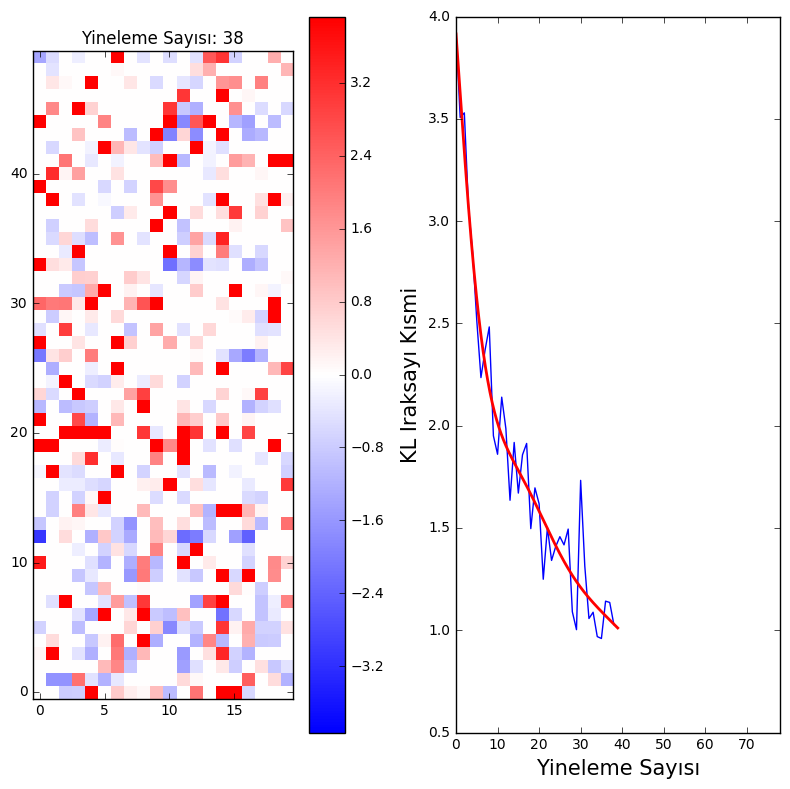

<function __main__.pltErrorVarianceHM>

In [26]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','white', 'red'],
                                           256) 

chosenStrategy = 1
chosenErrorMetric = 2

rmseHM = allError[chosenErrorMetric][chosenStrategy]
matrixHM = allErrorDiffs[chosenErrorMetric][chosenStrategy]
openedCellsHM = allOpenedCells[chosenStrategy]
varEstHM = allEstimationVariance[chosenStrategy]

xAxis = list(range(len(rmseHM)))
xp = np.linspace(0, EPOCH-1, 1000)
polDeg = 10
p30 = np.poly1d(np.polyfit(xAxis, rmseHM, polDeg))

vmax = rmseHM.max()
    
#matrixHM = diffErrorHM.copy()
for i in range(EPOCH-extraIter):
    #if openedCellsHM[i] == (-1,-1):
    #    break
    for oc in openedCellsHM[1+(i*cellOpenCount):]:
        if oc[0] == -1:
            break
        matrixHM[i][oc[0],oc[1]] = -varEstHM[i][oc[0],oc[1]]*vmax
    

def pltErrorVarianceHM(rc):
    fig = plt.figure(figsize=(8,8))
    plt.subplot(1, 2, 1)
    if rc == 0:
        plt.title("İlk Durum")
    elif rc <= (EPOCH-extraIter):
        plt.title("Yineleme Sayısı: " + str(rc))
    else:
        plt.title("Yineleme Sayısı: " + str(rc))
        
    img = plt.imshow(matrixHM[rc],interpolation='nearest',
                    cmap = cmap,
                    origin='lower',
                    vmax = vmax,
                    vmin = -vmax)
    plt.colorbar(img,cmap=cmap)
    
    plt.subplot(1, 2, 2)
    plt.plot( range(rc+1), rmseHM[:rc+1])
    
    try:
        xpRC = list(xp).index(xp[xp>=(rc+1)][0])
    except:
        xpRC = list(xp).index(xp[xp>=(rc)][0])
    plt.plot( xp[:xpRC], p30(xp)[:xpRC], "-", color='r', linewidth=2)
    
    plt.xlim(0,EPOCH)
    #plt.ylim(0,rmseHM.max()+1)
    font = {'size'   : 15}
    #plt.title("KL : " + str(p30(xp)[xpRC-1]))
    plt.xlabel("Yineleme Sayısı", **font)
    plt.ylabel(errorMetricLabels[chosenErrorMetric], **font)
    plt.tight_layout()
    plt.show()
    
    
interact(pltErrorVarianceHM, rc = (0, EPOCH-1, 1))

## Yoğun ve seyrek veri üzerinde, tanımlanmış beş strateji için 10’lu açarak kısmi KL ıraksayı değişim grafiği

Stratejilerin performanslarını, eşik değerine ne kadar hızlı ulaştıklarını karşılaştırarak ölçtük. Eşik değerine ulaşma metriği olarak *eğri altında kalan alanı* kullandık. En iyi strateji, eğri altında kalan alanı en az olandır.

Hata fonksiyonlarının asıl davranışını gözlemleyebilmek için fonksiyonlara polinom oturttuk. Bu polinomların salınımdan daha az etkilenmesi için ise bütün veriler gözlemlendikten
sonra 1000 yinelemeli Gibbs örnekleyicisi çalıştırdık.

51.27309890624195
44.32963005477559
81.05946289006324
54.52214938986193
78.09203997285168


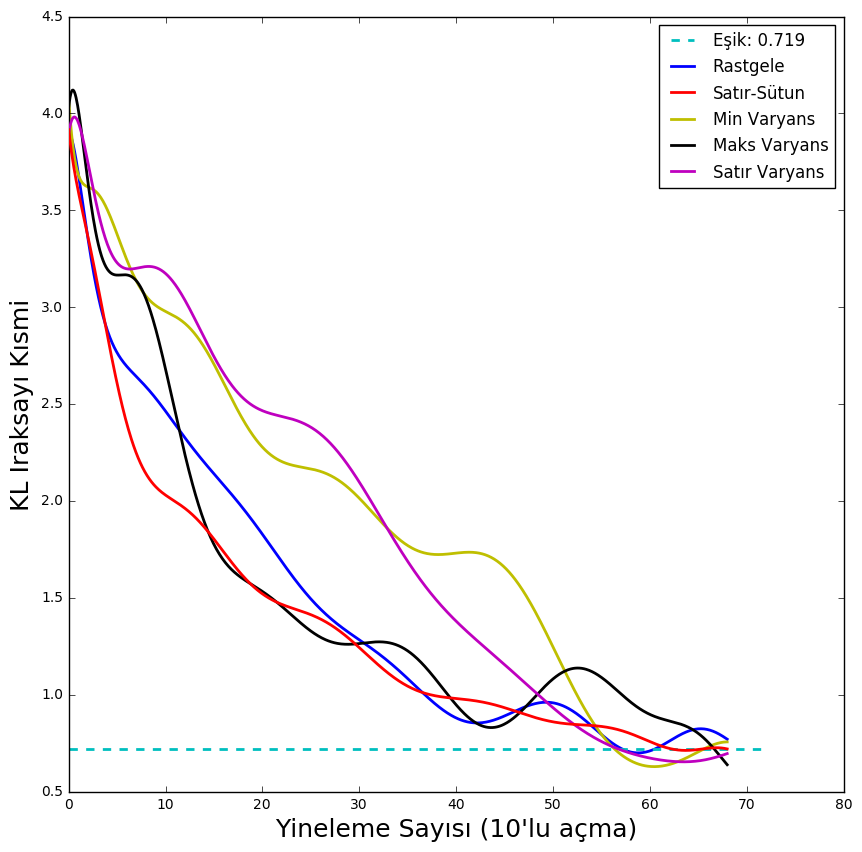

In [27]:
xAxis = list(range(len(allKLPartial[0])))
xp = np.linspace(0, EPOCH-1, 1000)
polDeg = 15

chosenErrorMetric = 2

errorFunction = allError[chosenErrorMetric].copy()
thr = 0
for rmse in errorFunction:
    thr += np.mean(rmse[-15:-5])
thr /= len(errorFunction)


fig = plt.figure(figsize=(10,10))

plt.plot(range(EPOCH - extraIter+15), (EPOCH - extraIter+15)*[thr], "--", color='c', label="Eşik: "+str(thr)[:5], linewidth=2)

aucTrapz = []
aucSimps = []


xpRC = list(xp).index(xp[xp>=(EPOCH - extraIter+10)][0])

for i, rmse in enumerate(errorFunction):
    p30 = np.poly1d(np.polyfit(xAxis, rmse, polDeg))
    aucTrapz.append(np.trapz(p30(xp)[:xpRC]-thr, x=xp[:xpRC]))
    aucSimps.append(np.trapz(p30(xp)[:xpRC], x=xp[:xpRC]))
    print(np.trapz(p30(xp)[:xpRC]-thr, x=xp[:xpRC]))
    zz = i
    if i == 1:
        zz = 10
    plt.plot( xp[:xpRC], p30(xp)[:xpRC], "-", label=strategyLabels[allStrategyLabels[i]], color=strategyColors[allStrategyColors[i]], linewidth=2, zorder=zz)

    
plt.xlim(0,)
#plt.ylim(0,)

font = {'size'   : 18}
plt.xlabel("Yineleme Sayısı (" + str(cellOpenCount) + "'lu açma)", **font)
plt.ylabel(errorMetricLabels[chosenErrorMetric], **font)

plt.legend()
plt.show()


## Vargılar

Bu çalışmamızda negatif olmayan matris ayrışımı için eşlenik Gamma önselleri ile hiyerarşik bir model inceledik ve çıkarımlar için Gibbs örnekleyicisi kullandık. Buradan yola çıkarak aktif eleman seçimi [7] problemine çözüm önerdik. Tanımladığımız beş stratejiyi KL ıraksayı ve KOKH metrikleri üzerinden karşılaştırdık. Yaptığımız deneyler ile satır-sütun stratejisinin etkili bir aktif ögrenme tekniği olduğunu gösterdik. Satır-sütun stratejisinin başarısının gözlemlenmemiş veriyi dengeli bir biçimde açıyor olmasına bağlıyoruz. Ayrıca bu stratejinin verinin içeriğinden bağımsız olarak tanımlanmış olması bu stratejiyi diğer alanlara da uygulanabilir kılıyor.

## Kaynaklar

[1] D. D. Lee and H. S. Seung, "Learning the parts of objects
with nonnegative matrix factorization.", Nature, 401:788–791, 1999.

[2]  A. T. Cemgil, "Bayesian inference in non-negative matrix
factorisation models.", Technical Report CUED/FINFENG/TR.609, University of Cambridge, July 2008. Submitted for publication to Computational Intelligence and Neuroscience

[3]  D. D. Lee and H. S. Seung, "Algorithms for non-negative matrix factorization.", Advances in neural information processing systems. 2001.	
 
[4] J. S. Liu, "Monte Carlo Strategies in Scientific Computing", Springer, New York, NY, USA, 2004.
 
[5] W. R. Gilks, S. Richardson, and D. J. Spiegelhalter, Eds., "Markov Chain Monte Carlo in Practice", CRC Press, London, UK, 1996.
 
[6] Harper, F. Maxwell, and Joseph A. Konstan, "The movielens datasets: History and context.", ACM Transactions on Interactive Intelligent Systems (TiiS) 5.4 (2016): 19.
 
[7] Silva, Jorge, and Lawrence Carin. "Active learning for online bayesian matrix factorization.", Proceedings of the 18th ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2012.